# The Brief

Since I'm a teacher, I always begin an assignment with the objectives and objectives front and center. In order to provide better context for this presentation, I'm starting with the email I received from Pascal. It outlines the major points I've been asked to discuss today and the expectations for how my presentation will be evaluated. 

> We want to see how well you're able to explain topics in statistics and data science. Write a short Jupyter notebook (and put it on github) covering these topics:
>
> 1. Hypothesis Testing: Let's talk about t-tests, p-values.  How are they related? What is it telling you?  How does it relate to precision-recall? What are the underlying assumptions?
> 2. Bayesian posterior inference: Explain Bayes' Rule.  Write some code to actually perform posterior sampling.  Work out an example using conjugate priors. How does this compare with hypothesis testing?  What are the underlying assumptions?
>
> Be prepared to give a short mock "lecture" (30 minutes) about these two topics with your prepared Jupyter notebooks.  The Jupyter notebooks are more meant to be notes for yourself and visual aids for your lecture. We'll be looking for
>
> 1. How well you present: remember that this material should be approachable, applied, and not just a series of formulas
> 2. How well you understand these topics in depth (the mathematics, the underlying assumptions behind ideas, etc ...)

Based on Pascal's email, I've created an example that touches on both hypothesis testing and Bayesian inference. It's based on my time in graduate school and my love of good food. 🍕

# The Story: New Haven Apizza

I did my graduate studies in New Haven, CT. One thing that New Haveners take very seriously is "apizza." There are several famous pizzerias in town, but my two favorites are [Pepe's Pizzeria](https://pepespizzeria.com) and [Modern Apizza](http://modernapizza.com).

<table>
  <tr>
    <th><img src="images/pepes-photo.jpg" alt="Pepe's Pizzeria"></th>
    <th><img src="images/modern-photo.png" alt="Modern Apizza"></th>
  </tr>
</table>

([Photo credit](https://www.eater.com/2014/7/2/6196371/the-road-to-the-38-ranking-new-havens-best-pizzas))

If there's one thing that almost all graduate students love, it's good pizza. I couldn't have survived my PhD without it. But if there's one thing we all need to watch out for, it's calories. When you're sitting in the library or lab all day, you've got to watch what you eat!

# Problem #1: Pepe's vs. Modern

## Collecting the Data

In 2006 my friends and I ate a lot of pizza. Not that we didn't eat a lot of pizza every year we were in New Haven, but this year was different because we all noticed that our clothes were suddenly a lot tighter. We decided to keep track of how much pizza we were eating and how many calories it was costing us. Almost every day (and sometimes more than once a day), we ate at Pepe's or Modern. To decide where to go, we flipped a coin. Once we got there, we asked our server to bring us any pizza they wanted with less than five toppings. One of my friends worked in nutrition, so she would save a slice and bring it back to her lab for testing with the calorimeter. We then recorded the date, pizzeria, toppings, and calories in a spreadsheet.

In 2017, I looked at the data we'd collected...

## Importing the Data

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('pizza-data.csv', index_col = 'date', parse_dates = True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 200 entries, 2006-01-01 02:10:21 to 2006-12-29 21:43:22
Data columns (total 3 columns):
pizzeria    200 non-null object
toppings    164 non-null object
calories    200 non-null int64
dtypes: int64(1), object(2)
memory usage: 6.2+ KB
None


,pizzeria,toppings,calories
date,,,
2006-01-01 02:10:21,Pepe's,"['Venison', 'Green Bell Peppers', 'Eggplant']",278
2006-01-02 03:28:57,Modern,"['BBQ Sauce', 'Falafel']",356
2006-01-02 12:14:35,Pepe's,"['Basil', 'Provolone']",314
2006-01-04 07:59:58,Pepe's,NaN,239
2006-01-09 22:21:53,Pepe's,"['BBQ Sauce', 'Habanero Peppers']",289


## Summary Statistics

In [3]:
# Split DataFrame into two groups
pepe_df = df[df['pizzeria'] == 'Pepe\'s']
modern_df = df[df['pizzeria'] == 'Modern']

# Define variables for later
pepe_m = pepe_df['calories'].mean()
pepe_std = pepe_df['calories'].std()
modern_m = modern_df['calories'].mean()
modern_std = modern_df['calories'].std()

# Print summary statistics
print('Pepe\'s Pizza Summary\n')
print(pepe_df['calories'].describe())
print('\nModern Pizza Summary\n')
print(modern_df['calories'].describe())

Pepe's Pizza Summary

count    100.000000
mean     293.360000
std       31.046567
min      235.000000
25%      273.000000
50%      293.500000
75%      310.000000
max      381.000000
Name: calories, dtype: float64

Modern Pizza Summary

count    100.000000
mean     336.150000
std       36.578234
min      269.000000
25%      308.750000
50%      331.000000
75%      365.000000
max      443.000000
Name: calories, dtype: float64


At first glance, it looked like Modern pizza had more calories per slice on average. And both seemed to be spread out equally around that mean.

## Visualization

To see how the data looked, I plotted two figures: A boxplot and a histogram.

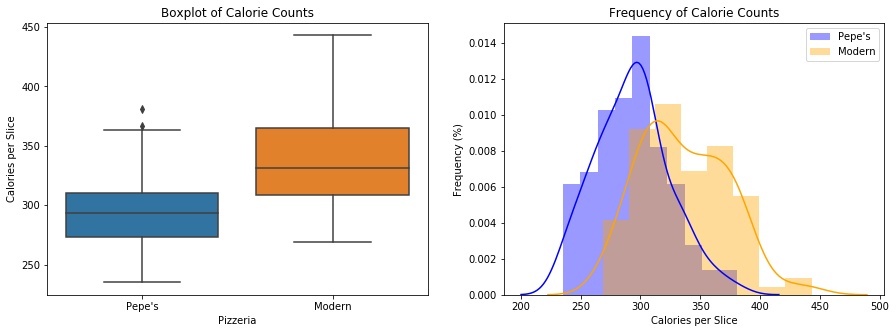

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

pepe_calories = pepe_df['calories']
modern_calories = modern_df['calories']

# Set fig layout
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Add boxplot
sns.boxplot(x="pizzeria", y="calories", data=df, order=['Pepe\'s', 'Modern'], ax=ax1)
ax1.set_xlabel('Pizzeria')
ax1.set_ylabel('Calories per Slice')
ax1.set_title('Boxplot of Calorie Counts')

# Add overlapping histograms
sns.distplot(pepe_calories, color="blue", label="Pepe\'s", ax=ax2)
sns.distplot(modern_calories, color="orange", label="Modern", ax=ax2)
ax2.set_xlabel('Calories per Slice')
ax2.set_ylabel('Frequency (%)')
ax2.set_title('Frequency of Calorie Counts')
ax2.legend()

plt.show()

The boxplot and histogram reinforced the impression that Modern pizza had more calories and Pepe's. However, there was also a lot of overlap between the two pizzerias, so it was hard to say that the two calorie counts were truly different.

## Hypothesis Testing

With the descriptive statistics and visualizations in mind, I turned to the numbers. In order to do hypothesis testing I needed to start with a **null hypothesis** (often written as $H_{0}$) and a **test statistic**. In this case, my null hypothesis was that there was no difference between the calorie counts of Pepe's and Modern pizza, and I would test that hypothesis using the mean calorie count of each pizzeria as my test statistic.

I took two approaches to testing my hypothesis. The first was running a simulation, and the second was running a t-test. 

### Simulation

For my simulation, I combined the Pepe's and Modern calorie counts into one pool. I then randomly divided that pool into two groups. Finally, I compared the difference in the means between those two groups with the difference I had first observed between Pepe's and Modern.

In [5]:
def permutation_sample(data_1, data_2):
    '''Takes two np arrays, permutes them, and returns two shuffled arrays of same size.'''
    # Concatenate the arrays
    data = np.concatenate((data_1, data_2))
    
    # Permute the combined array
    permuted_data = np.random.RandomState(seed=42).permutation(data)
    
    # Split permuted array
    perm_sample_1 = permuted_data[:len(data_1)]
    perm_sample_2 = permuted_data[len(data_1):]
    return perm_sample_1, perm_sample_2

def draw_perm_reps(data_1, data_2, func, size):
    '''Runs reps of function on permuted arrays. Returns array of results.'''
    # Ititialize array of replicates
    perm_replicates = np.empty(size)
    
    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)
        
        # Compute test statistic
        perm_replicates[i] - func(perm_sample_1, perm_sample_2)
    
    return perm_replicates

def diff_of_means(data_1, data_2):
    '''Calculates the difference between two means.'''
    diff = np.mean(data_1) - np.mean(data_2)
    return diff

In [6]:
# Compute diff of mean
empirical_diff_means = diff_of_means(pepe_calories, modern_calories)

# Draw permutation replicates
perm_replicates = draw_perm_reps(pepe_calories, modern_calories, diff_of_means, size = 10000)

# Compute and print p-value
p = np.sum(perm_replicates <= empirical_diff_means) / len(perm_replicates)
print('p-value =', p)

p-value = 0.0


If you run the block of code above several times, you'll see that it returns very small p-values. Sometimes they're so small that `numpy` just calculates them as zero! What this p-value is saying is that the chances of seeing a difference between Pepe's and Modern calorie counts that is this size or greater is very unlikely. This suggests that my null hypothesis is false. In other words, there really was a difference between the two pizzerias. If I was going to cut calories, I'd better stick with Modern.

### Calculation

For my calculation, I opted for a two-sided t-test using `scipy`. Before discussing the test itself, I want to point out that there are several assumptions that underlying a t-test:

1. *The scale of measurement is continuous*. In this case, it's true. Something you eat or drink can have anywhere between 0 (like a Diet Coke) and... well a lot of calories (like Modern's [Italian Bomb](http://modernapizza.com/menu/apizza-specialties/)).
2. *The data is collected from representative and random portion of the population*. This is also true. We randomly chose where to eat, and the pizza toppings were chosen randomly for us. And after {{df.shape[0]}} pizzas, we'd eaten pretty much every toppings combination possible, so we weren't favoring lighter or heavier options.
3. *The variance of the samples is homogeneous*. In other words, the calorie counts from Pepe's and Modern are equally spread out around their respective means. One way to test that the variances of two populations are equal is using the Bartlett’s test, which comes as part of the `scipy` library. So if our null hypothesis is that there is no difference in the respective variances of the Pepe's and Modern calorie counts, what does Bartlett have to say about it?

In [7]:
from scipy import stats
print('Pepe\'s variance:', np.round(np.var(pepe_calories), 2))
print('Modern variance:', np.round(np.var(modern_calories), 2))
var_test = stats.bartlett(pepe_calories, modern_calories)
print(var_test)

Pepe's variance: 954.25
Modern variance: 1324.59
BartlettResult(statistic=2.6364155071337314, pvalue=0.10443894251979742)


With a p-value of {{var_test[1].round(3)}}, I failed to reject the null hypothesis. That meant that I had to assume that Pepe's and Modern shared the same variance.

One last assumption that's often mentioned for the t-test is that the data should be normally distributed. However, the t-test can be used for non-normally distributed data when there's a lot of data (more than 30 in each group), so wasn't an issue here. My friends and I didn't eat all that pizza for nothing! 

So with all my assumptions checked, I moved on to my t-test. As with my simulation above, the null hypothesis was that there was no difference between the calorie counts of Pepe's and Modern pizza.

In [8]:
print(stats.ttest_ind(pepe_calories, modern_calories))

Ttest_indResult(statistic=-8.918733087736513, pvalue=3.156500371074793e-16)


Here, the p-value is so small that python is showing it to using using scientific notation. This means that the chance of seeing a difference between the two calorie counts that is this as big or bigger than the one we'd observed was virtually impossible. So, I rejected reject the null hypothesis and concluded that Modern pizza did have more calories than Pepe's. I knew there was a reason it tasted so good!

### Prediction and Precision vs. Recall

With all the data my friends and I collected, I wondered if I could put it to good use. What I wanted to do was be able to predict whether a slice of pizza came from Pepe's or Modern based only on its number of calories. 

The challenge of creating a good "Pizza Predictor" touches on the question of how p-values relate to precision and recall. Before I discuss my prediction effort, what are precision and recall? Prediction is rarely perfect, and I knew that there would be some slices I'd predict as belonging to Pepe's when they were actually from Modern and vice versa. So my predictions would fall into four categories:

<table>
  <tr>
    <th><img src="images/confusion-matrix-example.png" alt="Confusion Matrix"></th>
    <th><img src="images/confusion-matrix-example-precision.png" alt="Precision"></th>
    <th><img src="images/confusion-matrix-example-recall.png" alt="Recall"></th>
  </tr>
</table>

This figure is a great way to visualize precision and recall, which I've highlighted above.

* **Precision** focuses on the slices I *predict* as belonging to Pepe's, regardless of whether I'm right or wrong. It's a measure of how well my prediction technique identifies possible slices of Pepe's pizza. Precision keeps me from cheating by only identifying the 1 slice I'm most sure comes from Pepe's. Yes, I'd be right in 100% of my guesses, but there are 99 slices I would've missed.
* **Recall** focuses on the slices that are *actually from Pepe's*, regardless of whether I correctly say they are from Pepe's or incorrectly identify them as Modern. It's a measure of how well my technique identifies Pepe's pizza correctly. Recall keeps me from cheating by saying that all 200 slices come from Pepe's. Yes, I'd have identified all the Pepe's pizza correctly, but only by missing all of the Modern pizza.

For my predictive model. As above, I assumed that the calorie counts for both brands of pizza followed a normal distribution. I used that assumption to create a smoothed version of the distributions that I'd plotted above.

<Figure size 432x288 with 0 Axes>

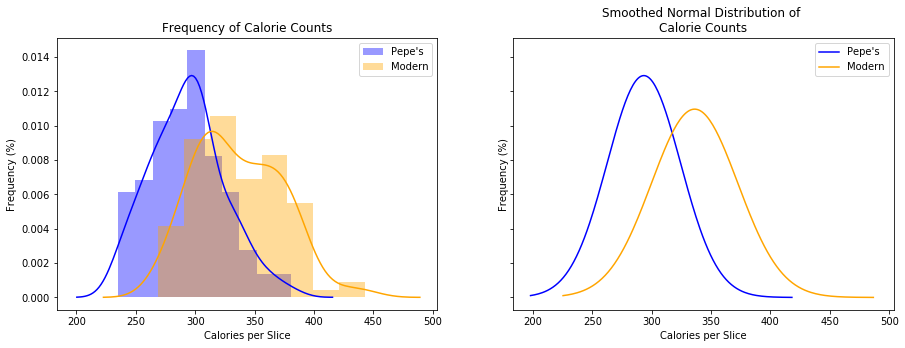

In [9]:
plt.clf()

# Set fig layout
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey = True, sharex = True)

# Add overlapping histograms
sns.distplot(pepe_calories, color="blue", label="Pepe\'s", ax=ax1)
sns.distplot(modern_calories, color="orange", label="Modern", ax=ax1)
ax1.set_xlabel('Calories per Slice')
ax1.set_ylabel('Frequency (%)')
ax1.set_title('Frequency of Calorie Counts')
ax1.legend()

# Add smoothed distributions
sns.distplot(pepe_calories, fit_kws={"color":"blue"}, kde=False, fit=stats.norm, hist=None, label="Pepe's", ax=ax2)
sns.distplot(modern_calories, fit_kws={"color":"orange"}, kde=False, fit=stats.norm, hist=None, label="Modern", ax=ax2)
ax2.set_title('Smoothed Normal Distribution of \nCalorie Counts')
ax2.set_xlabel('Calories per Slice')
ax2.set_ylabel('Frequency (%)')
ax2.legend()

plt.show()

Now I had a pretty picture to help with my predictions but, as with the original, there was a lot over overlap between Pepe's and Modern, which made it hard to identify the slices in the middle of the calorie range.

<Figure size 432x288 with 0 Axes>

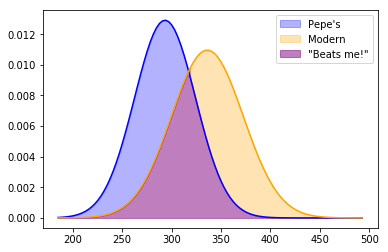

In [10]:
plt.clf()

# For the shading in this plot to work, I had to use Matplotlib directly instead of Seaborn

# Fit lines
pepe_params = stats.norm.fit(pepe_calories)
modern_params = stats.norm.fit(modern_calories)

# Set x-axis values
xmin = min(pepe_calories.min(), modern_calories.min())
xmax = max(pepe_calories.max(), modern_calories.max())
x = np.linspace(xmin-50, xmax+50, 100)

# Set y-axis values
y1 = stats.norm.pdf(x, *stats.norm.fit(pepe_calories))
y2 = stats.norm.pdf(x, *stats.norm.fit(modern_calories))

# Calculate PDF
pepe_pdf = stats.norm(*pepe_params).pdf(x)
modern_pdf = stats.norm(*modern_params).pdf(x)

# Get y-axis min
y = np.minimum(modern_pdf, pepe_pdf)

# Calculate overlap
cross = x[y1-y2 <= 0][0]

# Set layout
fig, ax = plt.subplots()

# Plot lines
ax.plot(x, pepe_pdf, label="Pepe's", color='blue')
ax.plot(x, modern_pdf, label="Modern", color='orange')

# Add shading
ax.fill_between(x,y1,y2, where=(x<=cross), color="blue", alpha=0.3)
ax.fill_between(x,y1,y2, where=(x>=cross), color="orange", alpha=0.3)
ax.fill_between(x, y, color='purple', alpha=0.5)

# Add legend
import matplotlib.patches as mpatches
blue_patch = mpatches.Patch(color='blue', alpha=0.3,label='Pepe\'s')
orange_patch = mpatches.Patch(color='orange', alpha=0.3,label='Modern')
purple_patch = mpatches.Patch(color='purple', alpha=0.5, label='"Beats me!"')
plt.legend(handles = [blue_patch, orange_patch, purple_patch])

plt.show()

In order to deal with this uncertainty, I decided to set a p-value as a threshold or cut-off point. Since I knew that Modern pizza had more calories, I focused on the higher end of the Pepe's distribution and chose a one-sided p-value of 0.05. With my threshold set, I plotted my Pizza Predictor and evaluated its performance.

In [11]:
from sklearn.metrics import confusion_matrix

def get_cut_off(pepe_m, pepe_std, percentile, one_sided = True):
    '''Takes p-value of Pepe's distribution and returns corresponding x-axis value for cut-off.'''
    if one_sided == True:
        n_std = stats.norm.ppf(1 - percentile)
    else:
        n_std = stats.norm.ppf(1 - percentile/2)
    pepe_cut_off = pepe_m + pepe_std * n_std
    return pepe_cut_off

def predict(cut_off, x):
    '''Takes cut-off and returns predicted label.'''
    if x <= cut_off:
        return 'Pepe\'s'
    else:
        return 'Modern'

def pepe_confusion(cut_off):
    '''Take cut-off and returns confusion matrix.'''
    df['prediction'] = df['calories'].apply(lambda x: predict(cut_off, x))
    y_true = df['pizzeria'].tolist()
    y_pred = df['prediction'].tolist()
    return confusion_matrix(y_true, y_pred)

<Figure size 432x288 with 0 Axes>

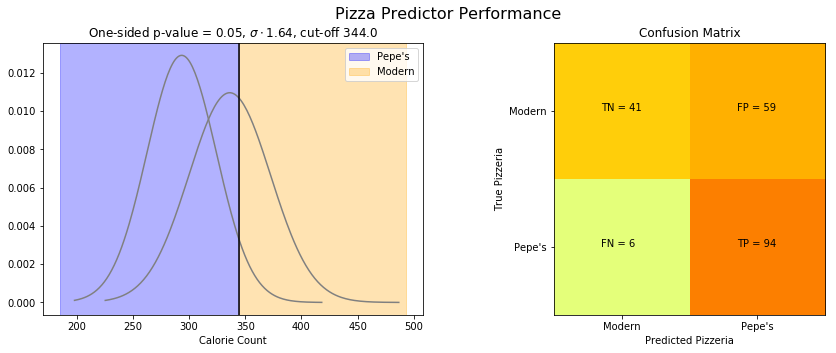

In [12]:
# Set p-value
p_value = 0.05

# Calculate distance of p-value from mean?
n_std = stats.norm.ppf(1 - p_value)

# Calculate cut-off and confusion matrix for axes 1 & 2
pepe_cut_off = get_cut_off(pepe_m, pepe_std, p_value)
cm = pepe_confusion(pepe_cut_off)

plt.clf()

# Layout
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharex = False, sharey = False)

# AX 1: PREDICTOR PLOT
sns.distplot(pepe_calories, fit_kws={"color":"grey"}, kde=False, fit=stats.norm, hist=None, label="Pepe's", ax = ax1)
sns.distplot(modern_calories, fit_kws={"color":"grey"}, kde=False, fit=stats.norm, hist=None, label="Modern", ax = ax1)

## Calculate coordinates for vertical line and shading
l1 = ax.lines[0]
l2 = ax.lines[1]
x1 = l1.get_xydata()[:,0]
x2 = l2.get_xydata()[:,0]
x1min = np.min(x1)
x2max = np.max(x2)

## Add vertical line and shading
ax1.axvline(x = pepe_cut_off, color = 'black')
ax1.axvspan(x1min, pepe_cut_off, alpha=0.3, color='blue')
ax1.axvspan(pepe_cut_off, x2max, alpha=0.3, color='orange')

## Add axis and plot titles
ax1.set_xlabel('Calorie Count')
ax.set_ylabel('Frequency (%)')
ax1.set_title('One-sided p-value = {p}, $\sigma\cdot{s}$, cut-off {c}'.format(p = p_value, s = n_std.round(2), c=pepe_cut_off.round()))

## Add legend
blue_patch = mpatches.Patch(color='blue', alpha=0.3, label='Pepe\'s')
orange_patch = mpatches.Patch(color='orange', alpha=0.3, label='Modern')
ax1.legend(handles = [blue_patch, orange_patch])

# AX 2: CONFUSION MATRIX
ax2.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)

## Add counts to figure
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        ax2.text(j-0.15,i, str(s[i][j])+" = "+str(cm[i][j]))

## Set formatting
class_names = ['Modern', 'Pepe\'s']
tick_marks = np.arange(len(class_names))

ax2.set_xlabel('Predicted Pizzeria')
ax2.set_ylabel('True Pizzeria')
ax2.set_xticks(tick_marks)
ax2.set_xticklabels(class_names)
ax2.set_yticks(tick_marks)
ax2.set_yticklabels(class_names)
ax2.set_title('Confusion Matrix')

# Set figure title
plt.suptitle('Pizza Predictor Performance', size = 16)

plt.show()

Based on the numbers in the confusion matrix, I calculated precision and recall. I also added accuracy, the percentage of slices that were correctly identified as either Pepe's or Modern.

In [13]:
# Assign values in confusion matrix to variables
s = [['tn','fp'], ['fn', 'tp']]
for i in range(2):
    for j in range(2):
        exec("{s} = {cm}".format(s=s[i][j], cm=cm[i][j]))

# Calculate precision, recall, accuracy
precision = tp / (tp + fp)
recall    = tp / (tp + fn)
accuracy  = (tp + tn) / (tp + tn + fp + fn)

# Print results
print('precision :', np.round(precision, decimals = 3))
print('recall    :', recall)
print('accuracy  :', accuracy)

precision : 0.614
recall    : 0.94
accuracy  : 0.675


The numbers showed that my first attempt was not great. I wasn't going to win any awards for {{np.round(precision * 100, 1)}}% accuracy. I had good recall, but my precision was even worse than my accuracy. 

I order to improve my Pizza Predictor, I had to choose another p-value. But instead of plugging in values one-by-one into my model, I plotted a range of p-values so that I could see how precision, recall, and accuracy changed.

In [14]:
# Create array of p-values
p_value_list = np.linspace(.99, 0.01, num = 99).round(2)

# Calculate corresponding x-axis cut-off values
cut_off_list = []
for p in p_value_list:
    cut_off = get_cut_off(pepe_m, pepe_std, p)
    cut_off_list.append(cut_off)

# Add p-values and cut-offs to DataFrame prec_rec
prec_rec = pd.DataFrame()
prec_rec['p-value'] = p_value_list
prec_rec['cut-off'] = cut_off_list

# Calulate precision, recall, and accuracy for all p-values, add to prec_rec
for lab, row in prec_rec.iterrows():
    cm = pepe_confusion(prec_rec.loc[lab, 'cut-off'])
    s = [['tn','fp'], ['fn', 'tp']]
    for i in range(2):
        for j in range(2):
            exec("{s} = {cm}".format(s=s[i][j], cm=cm[i][j]))

    try:
        precision = tp / (tp + fp)
    except ZeroDivisionError:
        precision = np.nan
    recall    = tp / (tp + fn)
    accuracy  = (tp + tn) / (tp + tn + fp + fn)
    
    prec_rec.loc[lab, 'precision'] = precision
    prec_rec.loc[lab, 'recall'] = recall
    prec_rec.loc[lab, 'accuracy'] = accuracy

<Figure size 432x288 with 0 Axes>

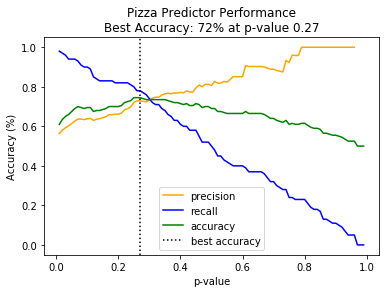

In [15]:
plt.clf()
    
# Layout
fig, ax = plt.subplots()

# Plot precision, recall, and accuracy
sns.lineplot(x='p-value', y='precision', data=prec_rec, label='precision', color = 'orange', ax = ax)
sns.lineplot(x='p-value', y='recall', data=prec_rec, label='recall', color = 'blue', ax = ax)
sns.lineplot(x='p-value', y='accuracy', data=prec_rec, label='accuracy',color = 'green', ax = ax)

# Add vertical line at highest accuracy
max_acc_y_index = prec_rec.index.get_loc(prec_rec['accuracy'].idxmax())
max_acc_x = prec_rec.loc[max_acc_y_index, 'p-value']
ax.axvline(x = max_acc_x, color = 'black', linestyle = ':', label = 'best accuracy')

# Formatting
ax.set_xlabel('p-value')
ax.set_ylabel('Accuracy (%)')
plt.title('Pizza Predictor Performance\nBest Accuracy: {a}% at p-value {p}'.format(a = max_acc_y_index, p=max_acc_x))
plt.legend()

plt.show()

My plot showed that, as the p-value went up, the precision increases and the recall decreased. I had the best accuracy when the p-value was  {{max_acc_x}}, approximately where precision and recall were equal.

# Problem #2: Mystery Pizza

## Using Pizzeria to Predict Calories

I had to face facts: My prediction tool wasn't very good. But not all was lost. The data my friends and I collected was still useful when it came to watching our calories.

<Figure size 432x288 with 0 Axes>

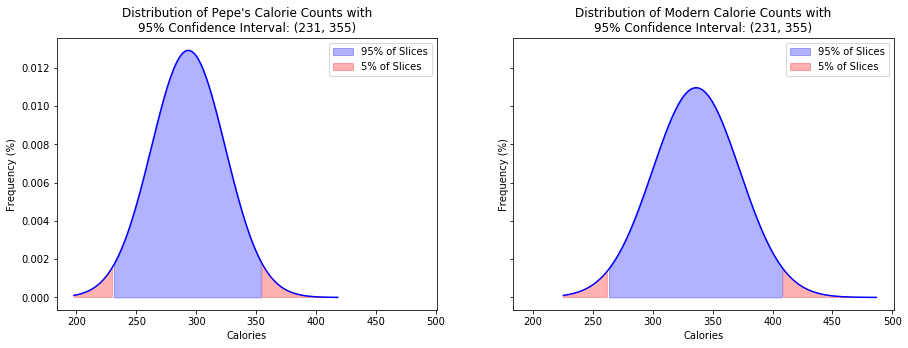

In [16]:
plt.clf()

# Layout
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey = True, sharex = True)

# Set legend colors
blue_patch = mpatches.Patch(color='blue', alpha=0.3, label='95% of Slices')
red_patch = mpatches.Patch(color='red', alpha=0.3, label='5% of Slices')

# AX 1: PEPE'S DISTRIBUTION
sns.distplot(pepe_calories, fit_kws={"color":"blue"}, kde=False, fit=stats.norm, hist=None, label="Pepe's", ax = ax1)

## Get coordinates for shading
l1 = ax1.lines[0]
x1 = l1.get_xydata()[:,0]
y1 = l1.get_xydata()[:,1]

## Calculate upper and lower bounds
ci_upper1 = round(pepe_m + pepe_std * 2)
ci_lower1 = round(pepe_m - pepe_std * 2)

## Add shading
ax1.fill_between(x1,y1, where = ((x1<=ci_lower1)|(x1>=ci_upper1)), color='red', alpha=0.3)
ax1.fill_between(x1,y1, where = ((x1>=ci_lower1)&(x1<=ci_upper1)), color='blue', alpha=0.3)

## Formatting
ax1.legend(handles = [blue_patch, red_patch])
ax1.set_xlabel('Calories')
ax1.set_ylabel('Frequency (%)')
ax1.set_title('Distribution of Pepe\'s Calorie Counts with\n95% Confidence Interval: ({l}, {u})'.format(l=ci_lower1, u=ci_upper1))

# AX 2: MODERN DISTRIBUTION
sns.distplot(modern_calories, fit_kws={"color":"blue"}, kde=False, fit=stats.norm, hist=None, label="Modern", ax = ax2)

## Get coordinates for shading
l2 = ax2.lines[0]
x2 = l2.get_xydata()[:,0]
y2 = l2.get_xydata()[:,1]

## Calculate upper and lower bounds
ci_upper2 = round(modern_m + modern_std * 2)
ci_lower2 = round(modern_m - modern_std * 2)

# Add Shading
ax2.fill_between(x2,y2, where = ((x2<=ci_lower2)|(x2>=ci_upper2)), color='red', alpha=0.3)
ax2.fill_between(x2,y2, where = ((x2>=ci_lower2)&(x2<=ci_upper2)), color='blue', alpha=0.3)

## Formatting
ax2.legend(handles = [blue_patch, red_patch])
ax2.set_xlabel('Calories')
ax2.set_ylabel('Frequency (%)')
ax2.set_title('Distribution of Modern Calorie Counts with\n95% Confidence Interval: ({l}, {u})'.format(l=ci_lower1, u=ci_upper1))

plt.show()

Take for example the above figures. When I eat at Pepe's Pizza, I know my slice will have between {{ci_lower1}} and {{ci_upper1}} calories  95% of the time. For Modern, a slice will have between {{ci_lower2}} and {{ci_upper2}}.

Similarly, knowing which pizzeria I'm in is also useful when I know how many calories are in a slice. If I'm eating at Pepe's and I know my slice has 325 calories, I also know what the probability of getting a slice that has that many calories or more. 

<Figure size 432x288 with 0 Axes>

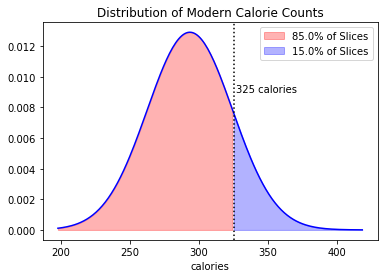

In [17]:
# Set calories
calories = 325

plt.clf()

# Set layout
fig, ax = plt.subplots()

# Plot Pepe's distribution
sns.distplot(pepe_calories, fit_kws={"color":"blue"}, kde=False, fit=stats.norm, hist=None, ax=ax)

# Get coordinates for shading
l1 = ax.lines[0]
x1 = l1.get_xydata()[:,0]
y1 = l1.get_xydata()[:,1]

# Add vertical line
ax.axvline(x = calories, color = 'black', linestyle = ':', label = '{c} calories'.format(c=calories))

# Add shading
ax.fill_between(x1,y1, where = (x1<=calories), color='red', alpha=0.3)
ax.fill_between(x1,y1, where = ((x1>=calories)), color='blue', alpha=0.3)

# Calculate mu and sigma
mu, sigma = stats.norm.fit(pepe_calories)[0], stats.norm.fit(pepe_calories)[1]

# Use mu and sigma to create labels for legend
blue = stats.norm(mu, sigma).cdf(calories) * 100
red = 100 - blue

# Add legend
blue_patch = mpatches.Patch(color='blue', alpha=0.3, label='{r}% of Slices'.format(r=red.round()))
red_patch = mpatches.Patch(color='red', alpha=0.3, label='{b}% of Slices'.format(b=blue.round()))
plt.legend(handles = [red_patch, blue_patch])

# Add label for vertical
plt.text(calories + 2, 0.009, '{c} calories'.format(c=calories))

plt.title('Distribution of Modern Calorie Counts')

plt.show()

If I wanted to represent the above figure with an equation, it would look like this: 

$0.15 = P(🍕 \geq 325 | \mbox{Pepe's})$

Here's the translation in plain English: *"Given that I'm eating at Pepe's, the probability that my slice has 325 or more calories is 15%."*

## Using Calories to Predict Pizzeria

The only problem with the probability I figured out above is that it doesn't work in reverse. In other words, if I was eating a slice and all I knew was that it had 325 calories, how could I predict which pizzeria had made it? That equation would look like this:

$🤔 = P(\mbox{Pepe's}|🍕=325)$

Or, again, in English: *"Given that my slice has 325 calories, what's the probability that it came from Pepe's?"* (I'm only mentioning Pepe's because if I know it doesn't come from Pepe's then I can be sure it came from Modern.)

This is precisely the question that I ran into when I went to a happy hour event at my friend's lab. Her advisor had bought 10 pizzas and served them to the group on trays. With no pizza boxes visible, we couldn't know whether the pizza had come from Pepe's or Modern. Luckily, we still had access to the calorimeter and could find out the calorie counts.

The way to figure out this problem is with Bayesian inference, which allows you answer these sorts of "reverse" questions by using information you already know about the data. The process has three steps:  

1. Start with a **prior**: A probability distribution representing what you know before seeing the new data. 
2. Choose a **generative model**: Your best guess about the character of the new data.
3. Interpret your **posterior**: A probability distribution representing what you know after seeing the new data.

To solve the mystery pizza problem, I needed to start with some sort of prior. In this case, I already knew that a pizza slice — whether it's Pepe's or Modern — had between {{df['calories'].min()}} and {{df['calories'].max()}} calories. I gave myself some padding (say, 30 calories on either side) and then created a uniform prior distribution. This is a fancy way of saying that I started under the assumption that all slices of pizza were equally likely to contain between {{df['calories'].min() - 30}} and {{df['calories'].max() + 30}} calories.

<Figure size 432x288 with 0 Axes>

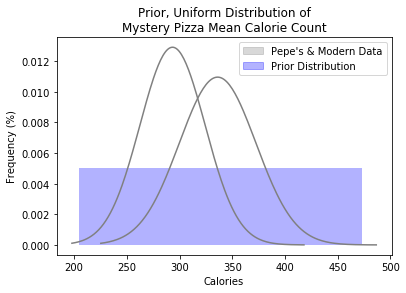

In [18]:
import matplotlib.patches as patches

plt.clf()

# Layout
fig, ax = plt.subplots()

# Plot Pepe's and Modern distributions
sns.distplot(pepe_calories, fit_kws={"color":"grey"}, kde=False, fit=stats.norm, hist=None, label="Pepe's", ax=ax)
sns.distplot(modern_calories, fit_kws={"color":"grey"}, kde=False, fit=stats.norm, hist=None, label="Modern", ax=ax)

# Plot prior distribution
padding = 30
prior_mu_min = df['calories'].min() - padding
prior_mu_max =  df['calories'].max() + padding
uniform = patches.Rectangle((prior_mu_min, 0), prior_mu_max - prior_mu_min, 0.005, linewidth=1.0, facecolor = 'blue', alpha = 0.3)
ax.add_patch(uniform)

# Add legend
blue_patch = mpatches.Patch(color='blue', alpha=0.3, label='Prior Distribution')
grey_patch = mpatches.Patch(color='grey', alpha=0.3, label='Pepe\'s & Modern Data')
plt.legend(handles = [grey_patch, blue_patch])

# Formatting
plt.xlabel('Calories')
plt.ylabel('Frequency (%)')
plt.title('Prior, Uniform Distribution of\nMystery Pizza Mean Calorie Count')

plt.show()
plt.clf()

For my generative model, I assumed that the calorie counts for the mystery pizza were distributed normally (like I had done with the hypothesis test). I also created a uniform distribution for the standard deviation and assumed that it, too, was distributed normally.

With all those assumptions in place, I measured the calories for each of the 15 slices.

In [19]:
# Import data, print info
mystery_df = pd.read_csv('mystery-pizza-data.csv')
print(mystery_df.info())
mystery_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 2 columns):
toppings    15 non-null object
calories    15 non-null int64
dtypes: int64(1), object(1)
memory usage: 320.0+ bytes
None


,toppings,calories
0,"['Egg', 'Crackerbread']",339
1,['Provolone'],311
2,"['Venison', 'Peperoncini', 'Alfredo Sauce']",364
3,['Squid'],321
4,['Sun-Dried Tomatoes'],311


Finally, I used my new data to "update" my prior and create a posterior distribution.

In [20]:
import pymc3 as pm

# Set parameters for prior
prior_sigma_min = 0
prior_sigma_max = prior_sigma_min + df['calories'].std() * 2

with pm.Model() as model:
    # Define priors
    mystery_mu = pm.Uniform('Mystery Pizza Mean', lower = prior_mu_min, upper = prior_mu_max)
    mystery_sigma = pm.Uniform('Mystery Pizza SD', lower = prior_sigma_min, upper = prior_sigma_max)
    
    # Define likelihood (generative model)
    mystery_pizza = pm.Normal('mystery', mu=mystery_mu, sd=mystery_sigma, observed=mystery_df['calories'].values)
    
    # Inference (update priors to get posterior)
    trace = pm.sample(2000, cores=2, tune=2500)

# NOTE: If you're running this notebook on Binder, this cell will take some time to run.
# And you can ignore these warnings:
# WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
# WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.

/Users/nicholascifuentes-goodbody/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Mystery Pizza SD, Mystery Pizza Mean]
Sampling 2 chains: 100%|██████████| 9000/9000 [00:03<00:00, 2280.29draws/s]


<Figure size 432x288 with 0 Axes>

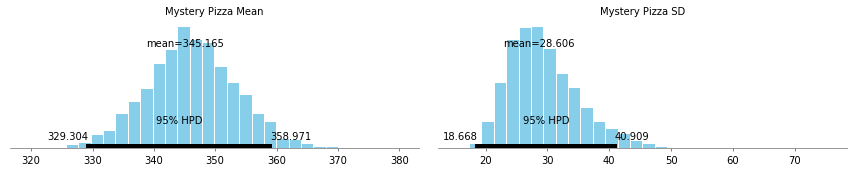

In [21]:
plt.clf()
varnames=['Mystery Pizza Mean','Mystery Pizza SD']
pm.plot_posterior(trace, varnames=varnames)
plt.show()
plt.clf()
mystery_p_mean = trace['Mystery Pizza Mean']
mystery_p_std  = trace['Mystery Pizza SD']

Looking at the posterior distributions, I knew that the mean calorie count of my mystery pizza was likely between {{np.round(mystery_p_mean.mean() - mystery_p_mean.std() * 2).astype('int')}} and {{np.round(mystery_p_mean.mean() + mystery_p_mean.std() * 2).astype('int')}}, and the standard deviation was between {{np.round(mystery_p_std.mean() - mystery_p_std.std() * 2).astype('int')}} and {{np.round(mystery_p_std.mean() + mystery_p_std.std() * 2).astype('int')}}. So I plotted the range of possibilities in a heat map, where I also included the information I already knew about Pepe's and Modern.

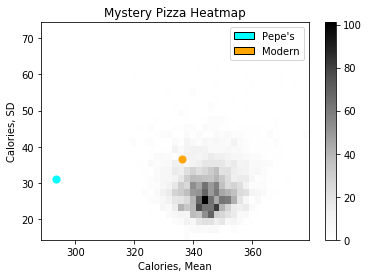

In [22]:
plt.clf()

# Set parameters
n_bins = 30
heatmap, xedges, yedges = np.histogram2d(mystery_p_mean, mystery_p_std, bins=n_bins)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

# Plot heatmap
plt.imshow(heatmap.T, extent=extent, origin='lower', aspect ='auto', cmap = plt.cm.Greys)
plt.colorbar()

# Plot prior Pepe's and Modern data
plt.scatter(pepe_calories.mean(), pepe_calories.std(), s=200, c='cyan', marker='.')
plt.scatter(modern_calories.mean(), modern_calories.std(), s=200, c='orange', marker='.')

# Add legend
blue_patch = mpatches.Patch(facecolor='cyan', label='Pepe\'s', edgecolor = 'black')
orange_patch = mpatches.Patch(facecolor='orange', label='Modern', edgecolor = 'black')
plt.legend(handles = [blue_patch, orange_patch])

# Formatting
plt.xlabel('Calories, Mean')
plt.ylabel('Calories, SD')
plt.title('Mystery Pizza Heatmap')

plt.show()

I also calculated the distance between the black cluster and both Pepe's and Modern.

In [23]:
import math

def get_distance (m_mean, m_std, series):
    '''Takes arrays of mystery pizza mean and std, and series of calorie counts.
    Calculates distance between (1) mean pizza mean and std, and (2) calorie count mean and std.'''
    m_mean = m_mean.mean()
    m_std = m_std.mean()
    k_mean = series.mean()
    k_std = series.std()
    dist = math.hypot(m_mean - k_mean, m_std - k_std)
    return dist

def compare_distances(m_mean, m_std, pepe, modern):
    '''Takes arrays of (1) mystery pizza mean and (2) std; series for (1) Pepe's and (2) Modern calorie counts.
    Calculates whether Pepe's or Modern is closer.'''
    dist_pepe = get_distance(m_mean, m_std, pepe)
    dist_modern = get_distance(m_mean, m_std, modern)
    if dist_pepe < dist_modern:
        response = 'Pepe\'s was closer'
    elif dist_pepe > dist_modern:
        response = 'Modern was closer'
    else:
        reponse = 'Pepe\'s and Modern were equally close'
    print(response)
    return response

In [24]:
closest_pizzeria = compare_distances(m_mean = mystery_p_mean, 
                                     m_std = mystery_p_std, 
                                     pepe = pepe_calories, 
                                     modern = modern_calories)

Modern was closer


Between the heatmap and my calculation, it was clear that {{closest_pizzeria}}. So the answer was solved. Based on prior knowledge we had gained from the hundreds of slices we'd eaten, we were able to determine that the 15 new slices had come that pizzeria. Mystery solved thanks to Bayesian inference!

# Conclusion